# Calculate and Parse LFP with velocity

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from sklearn import preprocessing

In [60]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity
from statsmodels.stats.descriptivestats import sign_test

In [5]:
import collections

In [6]:
import matplotlib

In [7]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [9]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [10]:
OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3"}

In [11]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [12]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.1
RESAMPLE_RATE=1000

In [13]:
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5 to 10 cm/s", 3: "10cm/s+"}

In [14]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [15]:
MERGED_TRIALS_AND_VIDEO.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,chunked_baseline_subject_thorax_to_agent_distance,chunked_trial_subject_thorax_to_agent_distance,chunked_baseline_subject_and_agent_to_reward_port_distance_ratio,chunked_trial_subject_and_agent_to_reward_port_distance_ratio,binned_trial_subject_thorax_to_reward_port_distance,binned_trial_agent_thorax_to_reward_port_distance,binned_baseline_subject_thorax_to_reward_port_distance,binned_baseline_agent_thorax_to_reward_port_distance,binned_baseline_subject_thorax_to_agent_distance,binned_trial_subject_thorax_to_agent_distance
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,1030879,20230617_115521_standard_comp_to_omission_D1_s...,1029,1.0,1-1_t1b3L_box1,lose_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[12.65717198847138, 12.683871307928696, 14.880...","[16.205996400456687, 14.683460926448209, 10.78...","[0.604891584042554, 0.5436686554497678, 0.3929...","[8.855775558856838, 8.071331610027782, 6.34917...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,6909411,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,3430878,20230617_115521_standard_comp_to_omission_D1_s...,3425,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[25.320573976061063, 25.371420577329687, 25.41...","[28.298667296783595, 27.888632992419563, 26.34...","[15.7376508983956, 15.425234033778917, 14.3912...","[5.900235036905437, 5.7618199879648, 5.5222346...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,9209413,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,5730880,20230617_115521_standard_comp_to_omission_D1_s...,5720,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[10.449518193779662, 10.328848927104168, 9.348...","[14.112370366297414, 10.711508418394406, 6.929...","[0.44937492745252716, 0.9597410167684043, 1.26...","[0.14051079708270506, 0.2589369756582887, 0.40...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
3,13109412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,9630879,20230617_115521_standard_comp_to_omission_D1_s...,9612,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,"[22.46126034089424, 15.271962513097026, 9.7552...","[2.6010760116473928, 2.4955147120669183, 2.936...","[0.535834249250867, 0.5909067784974122, 0.4167...","[0.33382427611833676, 0.36024075728364263, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
4,16509409,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,13030876,20230617_115521_standard_comp_to_omission_D1_s...,13006,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_co

In [16]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,vHPC_baselineandtrial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,BLA_baselineandtrial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,LH_baselineandtrial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,MD_baselineandtrial_lfp_trace
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.07045184, -0.0958607, -0.054282565, 0.1512...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[0.31159526, 0.35909453, 0.18239723, -0.509192...","[2.0367692, 2.1165679, 2.162167, 2.2685654, 2....","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[0.78082824, 1.1788379, 0.8415931, -0.40104795...","[3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1...","[-0.9857927, -0.8746131, -0.7362562, -1.413216...","[1.3860394, 1.4873364, 1.7566382, 1.8208753, 1..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.30606127, 0.22405995, 0.28873706, 0.4100066...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[0.020899683, -0.05129922, 0.113998264, -0.416...","[0.30589536, 0.13679792, -0.064599015, -0.3381...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[0.91754913, 0.4466216, 0.64410734, 0.03342066...","[-1.1575702, -1.2699852, -1.3489795, -1.427973...","[-0.15318082, -0.16800477, 0.019765267, 0.1605...","[1.620752, 1.3415675, 1.4601592, 0.94132084, -...","[-0.15318082, -0.16800477, 0.019765267, 0.1605..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.2300198, -1.2323297, -1.3039365, -1.096045...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...","[-2.0025697, -1.9151709, -1.9436705, -1.552276...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.58941895, 0.25521234, 0.66233677, 0.416239...","[-0.20356221, -0.08203254, -0.18837102, -0.142...","[-0.32859758, -0.5361329, -0.97591007, -0.7609...","[0.088943705, 0.8770837, 1.2056813, 0.88696635...","[-0.32859758, -0.5361329, -0.97591007, -0.7609..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.1605378, 0.4169363, 0.64561605, 0.6756447, ...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...","[-1.2729807, -1.0468841, -0.8378873, -0.754288...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[2.7587237, 2.233108, 1.4796239, 0.93274033, 1...","[-2.4792056, -2.1480372, -1.8259835, -1.677109...","[-2.7720788, -2.5620728, -2.3125362, -2.062999...","[2.0802944, 1.7344022, 1.1192082, 0.4521305, 0...","[-2.7720788, -2.5620728, -2.3125362, -2.062999..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.30952612, 0.19056645, 0.4331056, 0.3638087...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-0.18809713, 0.108298354, -0.66878986, -0.944...","[-2.1469674, -2.0690687, -2.0937681, -2.152667...","[-2.1176548, -1.4522797, -1.0360405, -

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [17]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [18]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [19]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baselineandtrial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baselineandtrial_lfp_trace',
       'MD

In [20]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_and_tracks_list',
       'subject_id', 'agent_id', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'box_bottom_left',
       'reward_po

In [21]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [22]:
MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")

In [23]:
# Dropping all unnecessary columns
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "index" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "stamp" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "box" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "height" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "width" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "ratio" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "width" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=['individual_subj',
 'all_subj',
 'recording_name',
 'track_names',
 'subject_id',
 'corner_path',
 'corner_parts',
 'rescaled_locations',
 'reward_port'], errors="ignore")

In [24]:
MERGED_LFP_AND_SLEAP.head()

,time,recording_file,video_number,current_subject,mPFC_baseline_lfp_trace,mPFC_trial_lfp_trace,mPFC_baselineandtrial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,vHPC_baselineandtrial_lfp_trace,...,chunked_baseline_subject_thorax_to_reward_port_distance,chunked_baseline_agent_thorax_to_reward_port_distance,chunked_baseline_subject_thorax_to_agent_distance,chunked_trial_subject_thorax_to_agent_distance,binned_trial_subject_thorax_to_reward_port_distance,binned_trial_agent_thorax_to_reward_port_distance,binned_baseline_subject_thorax_to_reward_port_distance,binned_baseline_agent_thorax_to_reward_port_distance,binned_baseline_subject_thorax_to_agent_distance,binned_trial_subject_thorax_to_agent_distance
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[-1.2365645, -1.3354121, -1.5621803, -1.494343...","[-1.0679421, -0.7713992, -0.69580984, -1.13190...","[-1.2365645, -1.3354121, -1.5621803, -1.494343...","[0.20910755, 0.39620376, 0.7075067, 1.040821, ...","[-2.4841347, -2.1523926, -1.564376, -1.139872,...","[0.20910755, 0.39620376, 0.7075067, 1.040821, ...",...,"[28.585903309417724, 28.612173629780724, 28.76...","[26.569699395671368, 26.569636446152348, 26.71...","[12.65717198847138, 12.683871307928696, 14.880...","[16.205996400456687, 14.683460926448209, 10.78...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,6909411,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[0.24421181, 0.2616555, 0.4380307, 0.4729181, ...","[-0.8605559, -0.6492933, -0.37407047, -0.05233...","[0.24421181, 0.2616555, 0.4380307, 0.4729181, ...","[0.5377051, 0.70907897, 0.5219827, 0.3506089, ...","[-0.31916416, -0.08647305, 0.19810188, 0.49525...","[0.5377051, 0.70907897, 0.5219827, 0.3506089, ...",...,"[26.470165636525834, 26.552555114938006, 26.58...","[2.0669623327772233, 2.087810423790316, 2.1108...","[25.320573976061063, 25.371420577329687, 25.41...","[28.298667296783595, 27.888632992419563, 26.34...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,9209413,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...","[-0.094971254, -0.16862243, -0.12404409, -0.22...","[1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...","[0.7531016, 0.1776628, -0.37890917, -0.6980733...","[1.2908068, 1.0486822, 0.79712427, 0.55971646,...","[0.7531016, 0.1776628, -0.37890917, -0.6980733...",...,"[6.541034554933668, 7.658042609951379, 6.68316...","[5.354952344204761, 3.8922529523878606, 3.6667...","[10.449518193779662, 10.328848927104168, 9.348...","[14.112370366297414, 10.711508418394406, 6.929...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
3,13109412,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[-0.89156693, -1.0485603, -0.7539555, -0.38182...","[2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...","[-0.89156693, -1.0485603, -0.7539555, -0.38182...","[-0.72480136, -0.8631582, -0.610028, 0.1776628...","[2.0847864, 1.889829, 1.8442342, 1.9480019, 2....","[-0.72480136, -0.8631582, -0.610028, 0.1776628...",...,"[24.649473048770187, 17.41640339020378, 11.672...","[2.321691046872197, 2.255541846948652, 2.05544...","[22.46126034089424, 15.271962513097026, 9.7552...","[2.6010760116473928, 2.495

- Calcuating the power at each frequency band

In [25]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "lfp_trace" in col]

In [26]:
trace_columns

['mPFC_baseline_lfp_trace',
 'mPFC_trial_lfp_trace',
 'mPFC_baselineandtrial_lfp_trace',
 'vHPC_baseline_lfp_trace',
 'vHPC_trial_lfp_trace',
 'vHPC_baselineandtrial_lfp_trace',
 'BLA_baseline_lfp_trace',
 'BLA_trial_lfp_trace',
 'BLA_baselineandtrial_lfp_trace',
 'LH_baseline_lfp_trace',
 'LH_trial_lfp_trace',
 'LH_baselineandtrial_lfp_trace',
 'MD_baseline_lfp_trace',
 'MD_trial_lfp_trace',
 'MD_baselineandtrial_lfp_trace']

In [27]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    print(region_and_baseline_or_trial)
    
    MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,                                                                              time_window_duration=TIME_WINDOW_DURATION, time_window_step=TIME_WINDOW_STEP                                                                                                                                         ))

mPFC_baseline
mPFC_trial
mPFC_baselineandtrial
vHPC_baseline
vHPC_trial
vHPC_baselineandtrial
BLA_baseline
BLA_trial
BLA_baselineandtrial
LH_baseline
LH_trial
LH_baselineandtrial
MD_baseline
MD_trial
MD_baselineandtrial


In [28]:
for col in trace_columns:
    print(col)
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_multitaper".format(region_and_baseline_or_trial)].apply(lambda x: Connectivity.from_multitaper(x))

mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
mPFC_baselineandtrial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
vHPC_baselineandtrial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
BLA_baselineandtrial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
LH_baselineandtrial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace
MD_baselineandtrial_lfp_trace


In [29]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_frequencies".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.frequencies)

In [30]:
for col in trace_columns:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    MERGED_LFP_AND_SLEAP["{}_all_window_power".format(region_and_baseline_or_trial)] = MERGED_LFP_AND_SLEAP["{}_connectivity".format(region_and_baseline_or_trial)].apply(lambda x: x.power().squeeze())

In [31]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "multitaper" in col], errors="ignore")
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns=[col for col in MERGED_LFP_AND_SLEAP if "connectivity" in col], errors="ignore")

In [32]:
MERGED_LFP_AND_SLEAP.head()

,time,recording_file,video_number,current_subject,mPFC_baseline_lfp_trace,mPFC_trial_lfp_trace,mPFC_baselineandtrial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,vHPC_baselineandtrial_lfp_trace,...,vHPC_baselineandtrial_all_window_power,BLA_baseline_all_window_power,BLA_trial_all_window_power,BLA_baselineandtrial_all_window_power,LH_baseline_all_window_power,LH_trial_all_window_power,LH_baselineandtrial_all_window_power,MD_baseline_all_window_power,MD_trial_all_window_power,MD_baselineandtrial_all_window_power
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[-1.2365645, -1.3354121, -1.5621803, -1.494343...","[-1.0679421, -0.7713992, -0.69580984, -1.13190...","[-1.2365645, -1.3354121, -1.5621803, -1.494343...","[0.20910755, 0.39620376, 0.7075067, 1.040821, ...","[-2.4841347, -2.1523926, -1.564376, -1.139872,...","[0.20910755, 0.39620376, 0.7075067, 1.040821, ...",...,"[[0.06577321988470483, 0.052082635879580154, 0...","[[0.04846414060565818, 0.03825064948044874, 0....","[[0.023575046659821245, 0.0259331288137852, 0....","[[0.04846414060565818, 0.03825064948044874, 0....","[[0.027032997418407468, 0.018166732374995893, ...","[[0.01288291485133643, 0.008844910077795138, 0...","[[0.027032997418407468, 0.018166732374995893, ...","[[0.013389447797539401, 0.011412659820189668, ...","[[0.002244466090808307, 0.0025331166319085712,...","[[0.013389447797539401, 0.011412659820189668, ..."
1,6909411,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[0.24421181, 0.2616555, 0.4380307, 0.4729181, ...","[-0.8605559, -0.6492933, -0.37407047, -0.05233...","[0.24421181, 0.2616555, 0.4380307, 0.4729181, ...","[0.5377051, 0.70907897, 0.5219827, 0.3506089, ...","[-0.31916416, -0.08647305, 0.19810188, 0.49525...","[0.5377051, 0.70907897, 0.5219827, 0.3506089, ...",...,"[[0.032539283617105036, 0.08699398469617095, 0...","[[0.0340132424343444, 0.03206636184086895, 0.0...","[[0.002657767852156648, 0.003989197629651639, ...","[[0.0340132424343444, 0.03206636184086895, 0.0...","[[0.008502855173479387, 0.015217701904129594, ...","[[0.03030199158219578, 0.014992747343420865, 0...","[[0.008502855173479387, 0.015217701904129594, ...","[[0.0074992117767994125, 0.016418355320274948,...","[[0.026678488104208267, 0.013914742570160553, ...","[[0.0074992117767994125, 0.016418355320274948,..."
2,9209413,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...","[-0.094971254, -0.16862243, -0.12404409, -0.22...","[1.7249881, 1.7424319, 1.6862243, 1.4323217, 0...","[0.7531016, 0.1776628, -0.37890917, -0.6980733...","[1.2908068, 1.0486822, 0.79712427, 0.55971646,...","[0.7531016, 0.1776628, -0.37890917, -0.6980733...",...,"[[0.035239375118848115, 0.027637486699423487, ...","[[0.012289059066669621, 0.009292139966569149, ...","[[0.0037119450558186517, 0.002619719422275406,...","[[0.012289059066669621, 0.009292139966569149, ...","[[0.03448840301621292, 0.020628671692418846, 0...","[[0.005308566286017989, 0.005874774035704584, ...","[[0.03448840301621292, 0.020628671692418846, 0...","[[0.027042362861995257, 0.017938209005009965, ...","[[0.004514168344374293, 0.006898958492899059, ...","[[0.027042362861995257, 0.017938209005009965, ..."
3,13109412,20230617_115521_standard_comp_to_omission_D1_s...,1.0,1.1,"[-0.89156693, -1.0485603, -0.7539555, -0.38182...","[2.3956015, 2.1804626, 1.9730763, 1.9750146, 2...","[-0.89156693, -1.0485603, -0.7539555, -0.38182...","[-0.72480136, -0.8631582, -0.610028, 0.1776628...","[2.0847864, 1.889829, 1.8442342, 1.9480019, 2....","[-0.72480136, -0.8631582, -0.610028, 0.1776628...",...,"[[0.009280712523364161, 0.012663323047184746, ...","[[0.0009335891980081169, 0.017256753280199835,...","[[0.038861569247197914, 0.02332519656461228, 0...","[[0.0009335891980081169, 0.017256753280199835,...","[[0.0026066428774081424, 0.0069093357329332765...","[[0.038643923355670504, 0.02162783179648867, 0...","[[0.0026066428774081424, 0.0069093357329332765...","[[0.00478709

# Plotting spectrograms

In [33]:
power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "baselineandtrial_all_window_power" in col]

In [34]:
power_col

['mPFC_baselineandtrial_all_window_power',
 'vHPC_baselineandtrial_all_window_power',
 'BLA_baselineandtrial_all_window_power',
 'LH_baselineandtrial_all_window_power',
 'MD_baselineandtrial_all_window_power']

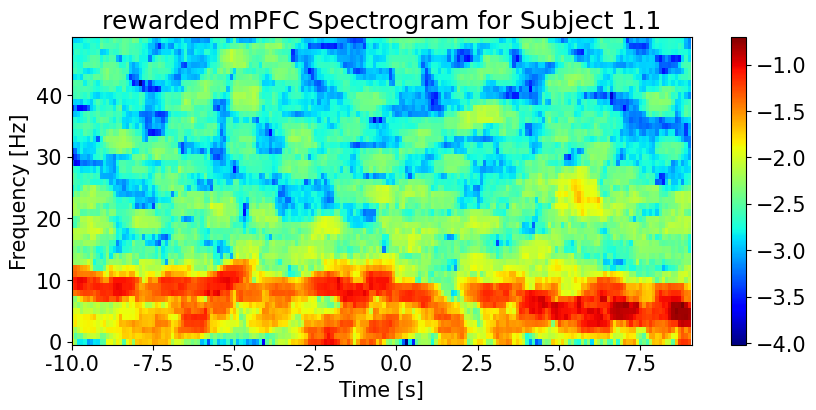

In [35]:
for index, row in MERGED_LFP_AND_SLEAP[(MERGED_LFP_AND_SLEAP["trial_outcome"] == "rewarded")].iterrows():
    for col in power_col:
        fig, ax = plt.subplots(figsize=(10, 4))
        trial_outcome = row["trial_outcome"]
        current_subject = row["current_subject"]
        region = col.split("_")[0]
        
        
        power_spectra = row[col][:, :50].T        
        power_spectra = np.log10(power_spectra)

        # power_spectra = power_spectra / reference_power.reshape(-1, 1)
        # power_spectra = preprocessing.normalize(power_spectra, axis=1)
        # power_spectra = np.log1p(power_spectra)
        # power_spectra = stats.zscore(power_spectra, axis=1)

        # Display the spectrogram

        plt.imshow(power_spectra, aspect='auto', origin='lower', cmap='jet')#, norm=matplotlib.colors.LogNorm())
        plt.colorbar()
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title('{} {} Spectrogram for Subject {}'.format(trial_outcome, region, current_subject))
        
        # Divide the current x-ticks by the divisor and set new x-tick labels
        new_tick_labels = [f"{tick/10-10}" for tick in ax.get_xticks()]       
        
        plt.xticks(ticks=ax.get_xticks(), labels=new_tick_labels)
        plt.xlim(0,191)
        
        
        plt.show()
        break
    break
        


# Grouping all the shared trial outcomes together

In [36]:
MERGED_LFP_AND_SLEAP.groupby(["trial_outcome", "current_subject"]).count()

time  recording_file  video_number  \
trial_outcome current_subject                                       
lose          1.1                 8               8             8   
              1.2                21              21            21   
              1.4                16              16            16   
omission      1.1                 7               7             7   
              1.2                 4               4             4   
              1.4                 7               7             7   
rewarded      1.1                31              31            31   
              1.2                16              16            16   
              1.4                39              39            39   
win           1.1                27              27            27   
              1.2                 5               5             5   
              1.4                 3               3             3   

                               mPFC_baseline_lfp_trace  mPFC_trial_lfp_trace  \
trial_outcome current_subject                                                  
lose          1.1                                    8                     8   
              1.2                                   21                    21   
              1.4                                   16                    16   
omission      1.1                                    7                     7   
              1.2                                    4                     4   
              1.4                                    7                     7   
rewarded      1.1                                   31                    31   
              1.2                                   16                    16   
              1.4                                   39                    39   
win           1.1                                   27                    27   
              1.2                                    5                     5   
              1.4                                    3                     3   

                               mPFC_baselineandtrial_lfp_trace  \
trial_outcome current_subject                                    
lose          1.1                                            8   
              1.2                                           21   
              1.4                                           16   
omission      1.1                                            7   
              1.2                                            4   
              1.4                                            7   
rewarded      1.1                                           31   
              1.2                                           16   
              1.4                                           39   
win           1.1                                           27   
              1.2                                            5   
              1.4                                            3   

                               vHPC_baseline_lfp_trace  vHPC_trial_lfp_trace  \
trial_outcome current_subject                                                  
lose          1.1                                    8                     8   
              1.2                                   21                    21   
              1.4                                   16                    16   
omission      1.1                                    7                     7   
              1.2                                    4                     4   
              1.4                                    7                     7   
rewarded      1.1                                   31                    31   
              1.2                                   16                    16   
              1.4                                   39                    39   
win           1.1                                   27                    27   
              1.2                                    5    

In [37]:
groupby_df  = MERGED_LFP_AND_SLEAP.groupby(["current_subject", "trial_outcome"])[power_col].agg({k: lambda x: np.mean(np.stack(x), axis=0) for k in power_col}).reset_index()


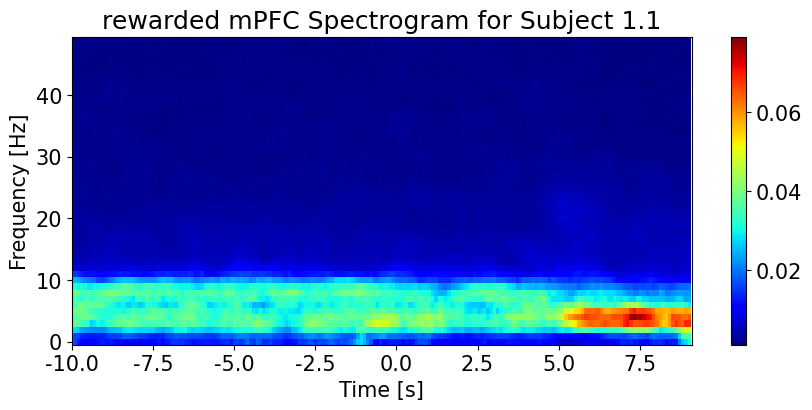

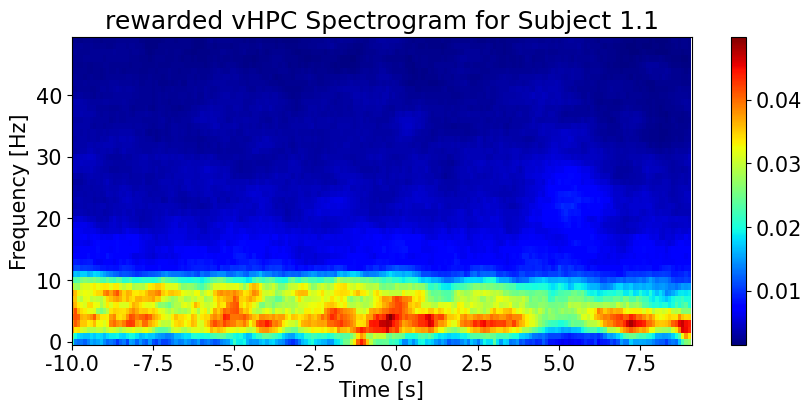

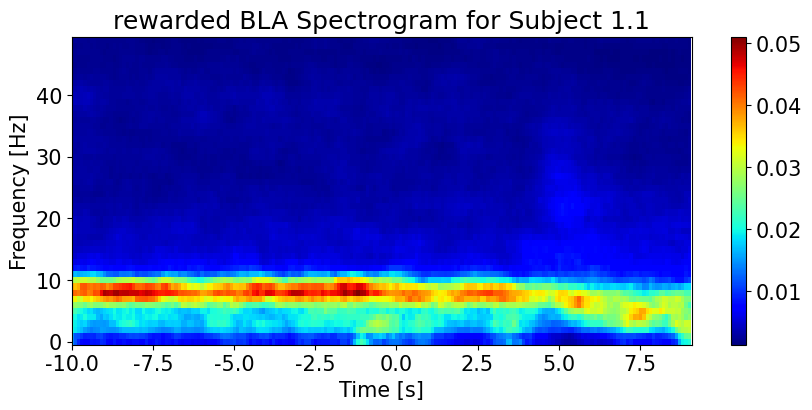

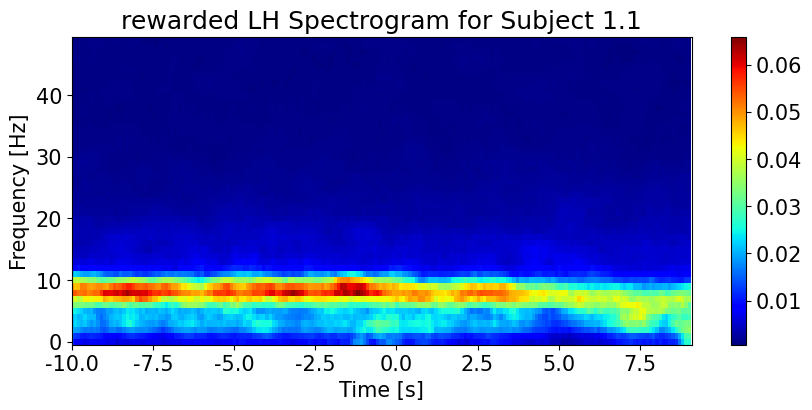

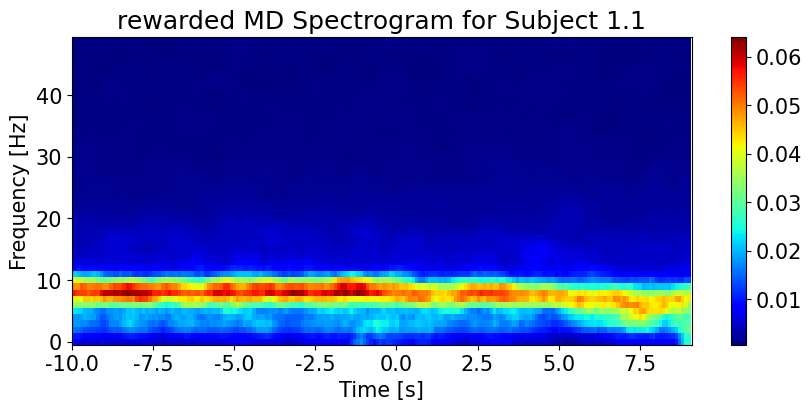

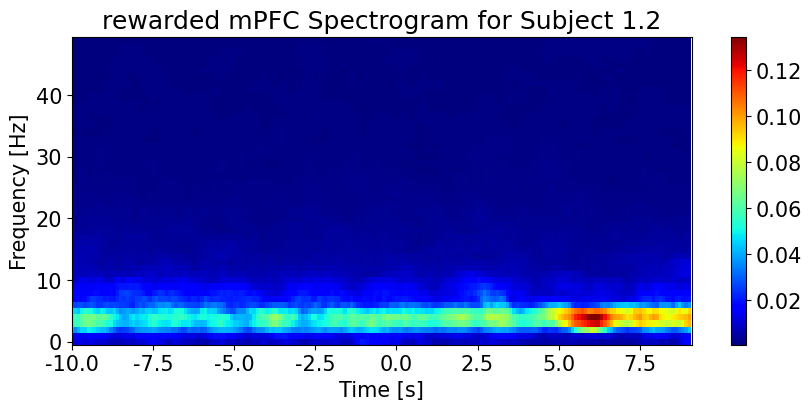

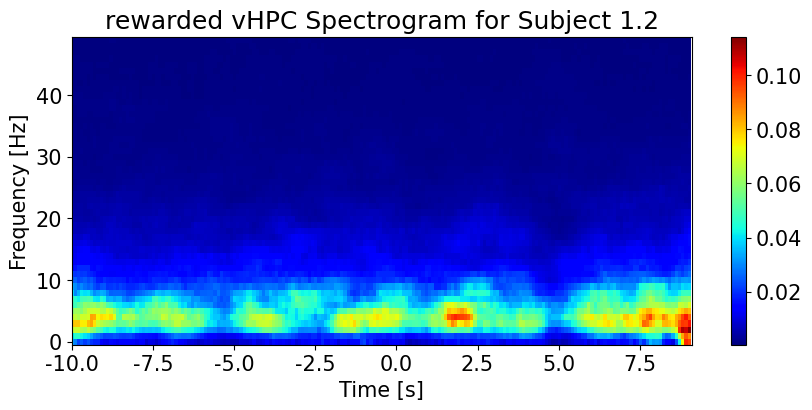

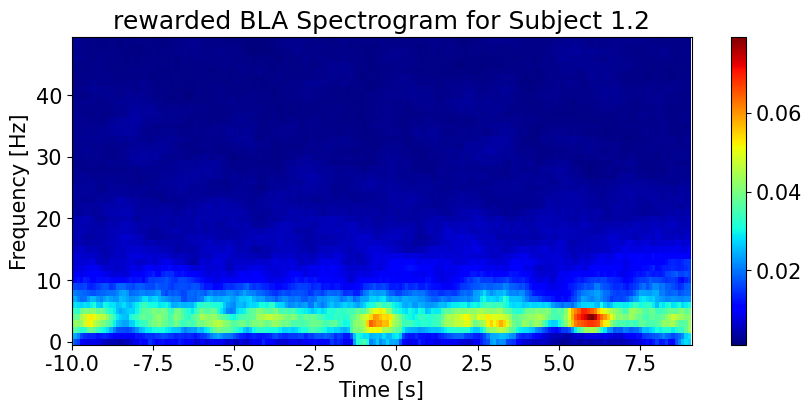

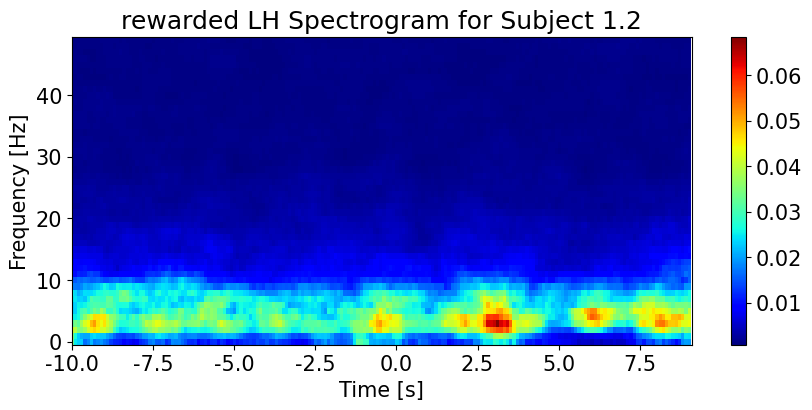

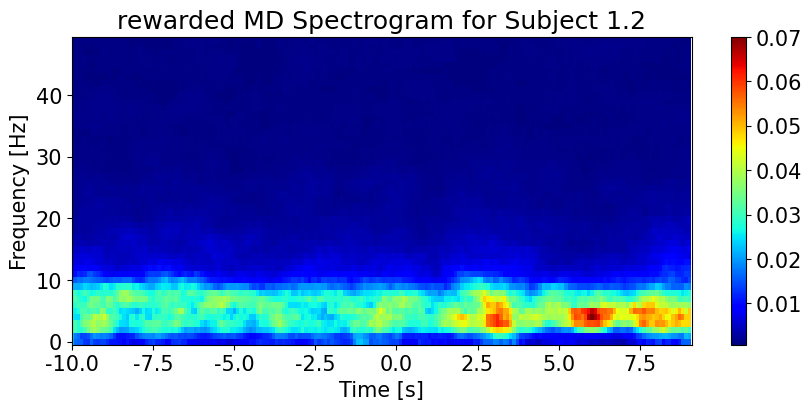

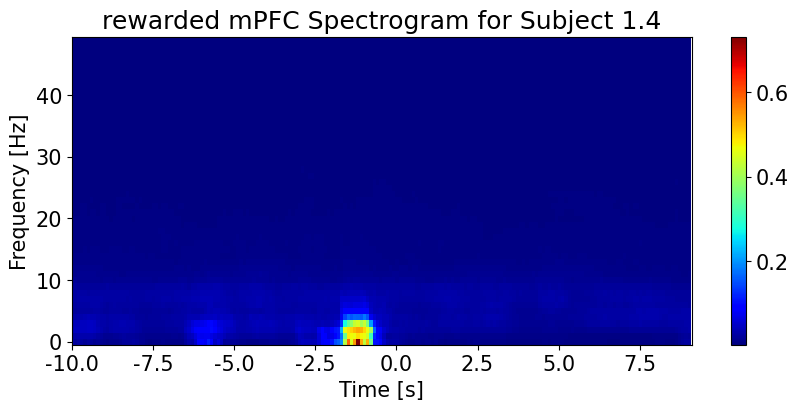

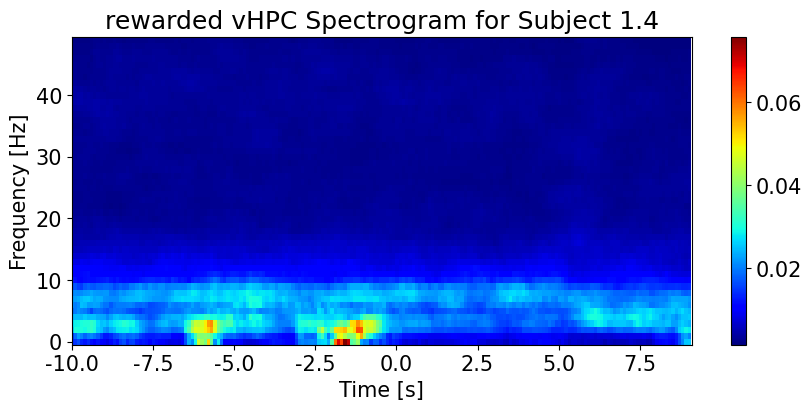

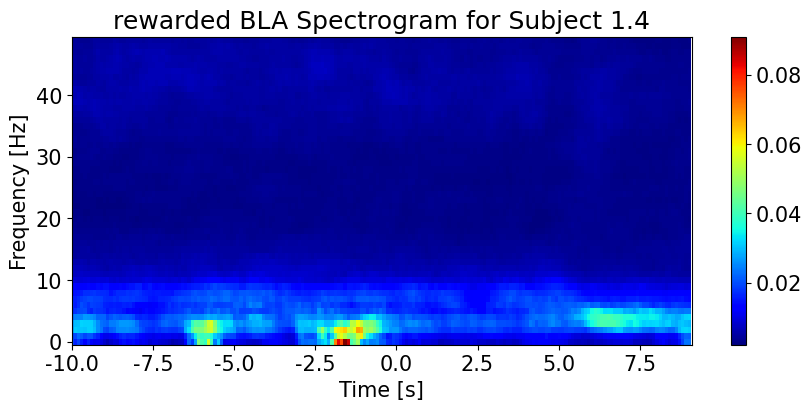

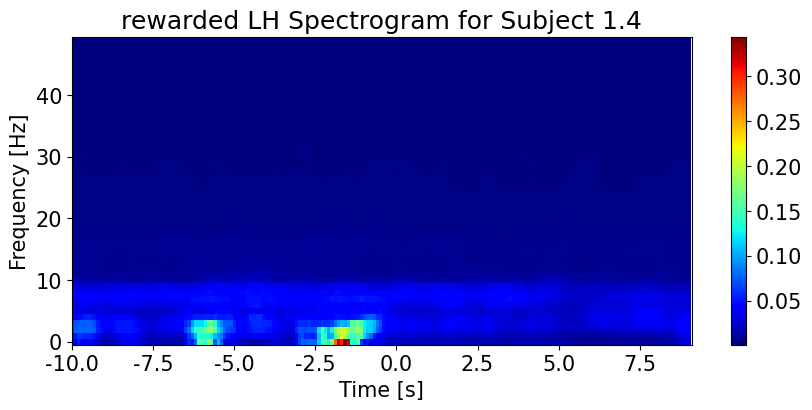

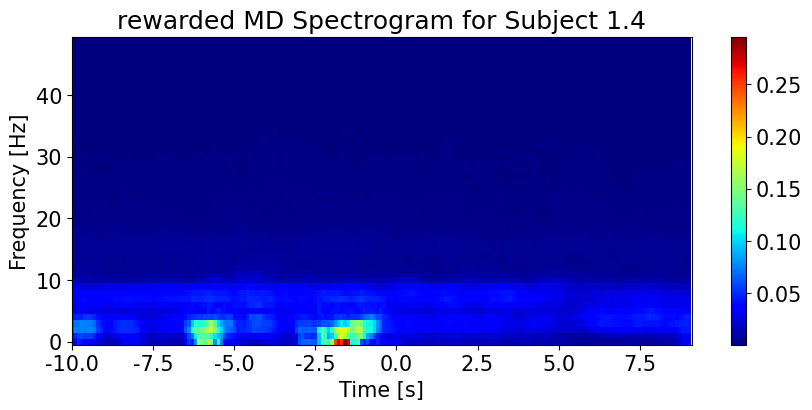

In [38]:
for index, row in groupby_df.iterrows():
    for col in power_col:
        trial_outcome = row["trial_outcome"]

        if trial_outcome != "rewarded":
            continue
        
        current_subject = row["current_subject"]
        region = col.split("_")[0]
        
        
        power_spectra = row[col][:, :50].T
        # power_spectra = np.log10(power_spectra)

        # power_spectra = np.log1p(power_spectra)
        # power_spectra = stats.zscore(power_spectra, axis=1)

        
        # Display the spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(power_spectra, aspect='auto', origin='lower', cmap='jet')
        plt.colorbar()
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title('{} {} Spectrogram for Subject {}'.format(trial_outcome, region, current_subject))
        
        # Divide the current x-ticks by the divisor and set new x-tick labels
        new_tick_labels = [f"{tick/10-10}" for tick in ax.get_xticks()]       
        
        plt.xticks(ticks=ax.get_xticks(), labels=new_tick_labels)
        plt.xlim(0,191)
        
        
        plt.show()

# Plotting fold change bar plots

In [39]:
MERGED_LFP_AND_SLEAP.columns

Index(['time', 'recording_file', 'video_number', 'current_subject',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       ...
       'vHPC_baselineandtrial_all_window_power',
       'BLA_baseline_all_window_power', 'BLA_trial_all_window_power',
       'BLA_baselineandtrial_all_window_power', 'LH_baseline_all_window_power',
       'LH_trial_all_window_power', 'LH_baselineandtrial_all_window_power',
       'MD_baseline_all_window_power', 'MD_trial_all_window_power',
       'MD_baselineandtrial_all_window_power'],
      dtype='object', length=102)

In [40]:
power_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "all_window_power" in col and "baselineandtrial" not in col]

In [41]:
for col in power_col:
    region_and_baseline_or_trial = "_".join(col.split("_")[:2])
    window_averaged_power_column = "{}_window_averaged_power".format(region_and_baseline_or_trial)
    print(region_and_baseline_or_trial)
    
    MERGED_LFP_AND_SLEAP[window_averaged_power_column] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.mean(x, axis=0))

    for band, (min_freq, max_freq) in BAND_TO_FREQ.items():
        MERGED_LFP_AND_SLEAP["{}_{}_band_power".format(region_and_baseline_or_trial, band)] = MERGED_LFP_AND_SLEAP[window_averaged_power_column].apply(lambda x: np.nanmean(x[min_freq:max_freq]))

mPFC_baseline
mPFC_trial
vHPC_baseline
vHPC_trial
BLA_baseline
BLA_trial
LH_baseline
LH_trial
MD_baseline
MD_trial


In [42]:
MERGED_LFP_AND_SLEAP.iloc[0]["mPFC_baseline_window_averaged_power"].shape

(500,)

In [43]:
trial_band_column = [col for col in MERGED_LFP_AND_SLEAP.columns if "band_power" in col and "trial" in col]

In [44]:
trial_band_column

['mPFC_trial_theta_band_power',
 'mPFC_trial_beta_band_power',
 'mPFC_trial_gamma_band_power',
 'vHPC_trial_theta_band_power',
 'vHPC_trial_beta_band_power',
 'vHPC_trial_gamma_band_power',
 'BLA_trial_theta_band_power',
 'BLA_trial_beta_band_power',
 'BLA_trial_gamma_band_power',
 'LH_trial_theta_band_power',
 'LH_trial_beta_band_power',
 'LH_trial_gamma_band_power',
 'MD_trial_theta_band_power',
 'MD_trial_beta_band_power',
 'MD_trial_gamma_band_power']

In [45]:
for col in trial_band_column:
    brain_region = col.split("_")[0]
    frequency_band = col.split("_")[2]
    baseline_col = col.replace("trial", "baseline")
    MERGED_LFP_AND_SLEAP["{}_{}_foldchange".format(brain_region, frequency_band)] = MERGED_LFP_AND_SLEAP[col] / MERGED_LFP_AND_SLEAP[baseline_col]

In [46]:
foldchange_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "foldchange" in col]

In [47]:
mean_foldchange_df = MERGED_LFP_AND_SLEAP.groupby(["trial_outcome"])[foldchange_col].mean()

In [48]:
mean_foldchange_df["color"] = mean_foldchange_df.index.map(OUTCOME_TO_COLOR)

In [84]:
sem_foldchange_df = MERGED_LFP_AND_SLEAP.groupby(["trial_outcome"])[foldchange_col].sem(ddof=0)

In [85]:
sem_foldchange_df

,mPFC_theta_foldchange,mPFC_beta_foldchange,mPFC_gamma_foldchange,vHPC_theta_foldchange,vHPC_beta_foldchange,vHPC_gamma_foldchange,BLA_theta_foldchange,BLA_beta_foldchange,BLA_gamma_foldchange,LH_theta_foldchange,LH_beta_foldchange,LH_gamma_foldchange,MD_theta_foldchange,MD_beta_foldchange,MD_gamma_foldchange
trial_outcome,,,,,,,,,,,,,,,
lose,0.046118,0.020663,0.020400,0.047971,0.030996,0.023141,0.432564,0.345484,0.059406,0.040953,0.023155,0.017142,0.040806,0.023921,0.016095
omission,0.081712,0.032170,0.028124,0.072336,0.047431,0.049548,0.041396,0.046627,0.055835,0.056573,0.030251,0.022996,0.051193,0.030096,0.022043
rewarded,0.033949,0.027754,0.017316,0.033062,0.023502,0.021787,0.030954,0.029786,0.022085,0.034458,0.024810,0.019996,0.033195,0.023022,0.019732
win,0.117256,0.111723,0.065262,0.107832,0.056353,0.031786,0.079726,0.065150,0.033700,0.087074,0.118203,0.085203,0.070647,0.093115,0.070831


In [65]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=foldchange_col)

In [66]:
grouped_MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.groupby(["trial_outcome"])[foldchange_col].agg(list)
# for col in foldchange_col:


In [67]:
grouped_MERGED_LFP_AND_SLEAP

,mPFC_theta_foldchange,mPFC_beta_foldchange,mPFC_gamma_foldchange,vHPC_theta_foldchange,vHPC_beta_foldchange,vHPC_gamma_foldchange,BLA_theta_foldchange,BLA_beta_foldchange,BLA_gamma_foldchange,LH_theta_foldchange,LH_beta_foldchange,LH_gamma_foldchange,MD_theta_foldchange,MD_beta_foldchange,MD_gamma_foldchange
trial_outcome,,,,,,,,,,,,,,,
lose,"[1.0925715968526046, 1.2544141864002822, 0.914...","[0.8942209500376035, 1.1778310288263494, 0.811...","[1.2456183271827856, 0.9753364751877228, 0.937...","[0.8727305736253635, 1.20634901574607, 0.81258...","[1.0821485552105627, 0.9871202081334641, 1.361...","[1.237313311693075, 1.0553920344291041, 1.0929...","[1.3026379392032814, 1.4533352429636732, 0.844...","[1.0093177413479255, 0.9824319717358322, 0.977...","[1.1236376632562082, 0.9848722454221973, 0.906...","[1.284146887658025, 1.2258794457093571, 0.8891...","[1.0109933201516033, 1.290656852794739, 0.7231...","[1.1384620645887613, 0.9713031308650646, 0.898...","[1.284732929504904, 1.1721341105772811, 0.8945...","[1.073853176819218, 1.2217771103896504, 0.8392...","[1.0770081154839102, 1.0000580979183722, 0.950..."
omission,"[1.4185784156364576, 0.9115301977061364, 0.692...","[1.0556218981814913, 0.9628777465246611, 0.844...","[1.031954380152566, 0.9171859954143465, 0.8990...","[1.28848457612797, 0.9267721651586225, 0.83641...","[1.1661643494225615, 0.7709176639467037, 1.188...","[1.189245981648587, 0.7960354471489427, 1.4555...","[1.1802453208605332, 1.0500226992541464, 0.866...","[0.9207534687773499, 0.7211377416057078, 1.357...","[1.2214791301389802, 0.8068677903853007, 1.511...","[1.423270643017777, 0.9389414258976565, 0.7052...","[1.0565864201023243, 0.7652357685738918, 1.015...","[1.0668503633948305, 0.9638714827574321, 1.173...","[1.3007344527542177, 0.904664043890617, 0.6625...","[1.0516056807527254, 0.7185830552387928, 0.961...","[1.0207223690417278, 0.9351570204773054, 1.073..."
rewarded,"[0.9579243241060552, 1.0056619194392051, 0.465...","[1.5416347419871108, 0.9736555133602559, 0.991...","[0.9542106090484117, 1.2032327750745178, 0.956...","[0.6171787339613981, 1.1664036625255756, 0.406...","[1.2813376979746973, 1.0814063669793088, 0.933...","[0.941270350785709, 1.247355629237259, 0.85808...","[0.6697203226703806, 1.037020389193555, 0.5292...","[1.6333733303314693, 1.0286292467220064, 0.985...","[0.9138908507701364, 0.9876144857570336, 1.034...","[0.7310818374529464, 1.1694603970125366, 0.468...","[1.1353017856069816, 1.120066961092012, 0.8604...","[1.003059125748603, 1.3646987408027207, 0.9554...","[0.7684981591172716, 1.1126115895811641, 0.547...","[1.0106582704168394, 1.1767428043742811, 0.762...","[1.0084773992871723, 1.41286383651469, 0.97084..."
win,"[1.2959508383927802, 1.7034247984276663, 0.851...","[1.1662490952931686, 0.822835468285953, 1.0375...","[1.1823638709710802, 1.1287589564707043, 0.864...","[1.0228059105835199, 1.4543738610307018, 0.893...","[0.9901209929959403, 1.421110926854046, 0.9334...","[1.1136558863451138, 1.1524983340297439, 0.850...","[1.246962510556095, 1.7801508796960133, 0.8617...","[1.5090049006579147, 1.2281914719666753, 0.998...","[1.0288306821330069, 1.2705400436000176, 0.850...","[1.27458690258125, 1.563841012711058, 0.813042...","[1.1134769356199186, 0.9657406780310493, 0.846...","[1.285438342834917, 1.1462687257989994, 0.9161...","[1.2665371355564412, 1.5106130080112723, 0.877...","[1.1018887202826033, 0.9046108335002578, 0.833...","[1.3230965776609813, 1.0922815899829603, 0.855..."


In [ ]:
grouped_df

In [55]:
# Function to add significance stars based on p-values
def add_significance_stars(ax, data):
    for i, (key, (value, p_value)) in enumerate(data.items()):
        # Determine the significance level and corresponding star(s)
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        
        # Add stars to the plot if significant
        if stars:
            ax.text(i, value, stars, ha='center', va='bottom', color='black', fontsize=20)


In [56]:
foldchange_col

['mPFC_theta_foldchange',
 'mPFC_beta_foldchange',
 'mPFC_gamma_foldchange',
 'vHPC_theta_foldchange',
 'vHPC_beta_foldchange',
 'vHPC_gamma_foldchange',
 'BLA_theta_foldchange',
 'BLA_beta_foldchange',
 'BLA_gamma_foldchange',
 'LH_theta_foldchange',
 'LH_beta_foldchange',
 'LH_gamma_foldchange',
 'MD_theta_foldchange',
 'MD_beta_foldchange',
 'MD_gamma_foldchange']

mPFC_theta_foldchange
lose
0.8933133075834689
omission
0.54766845703125
rewarded
0.04381887535082141
win
0.6562793096527457


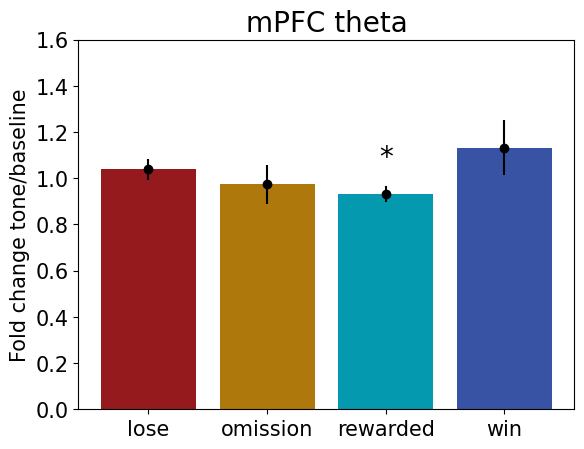

mPFC_beta_foldchange
lose
0.0841903160454649
omission
0.328948974609375
rewarded
0.000784483567222045
win
0.004779105598572642


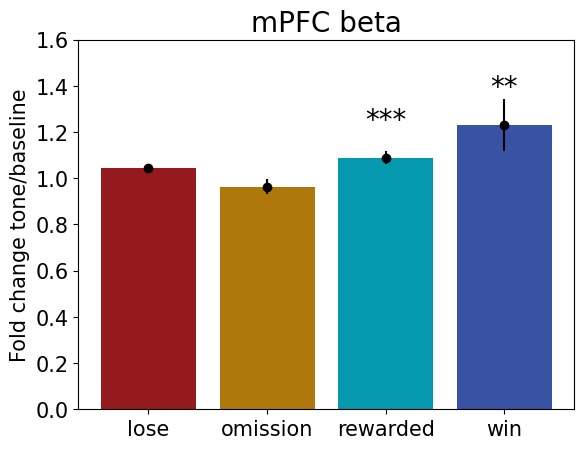

mPFC_gamma_foldchange
lose
0.12558989826936795
omission
0.2633209228515625
rewarded
0.017451190266592812
win
0.35920803993940353


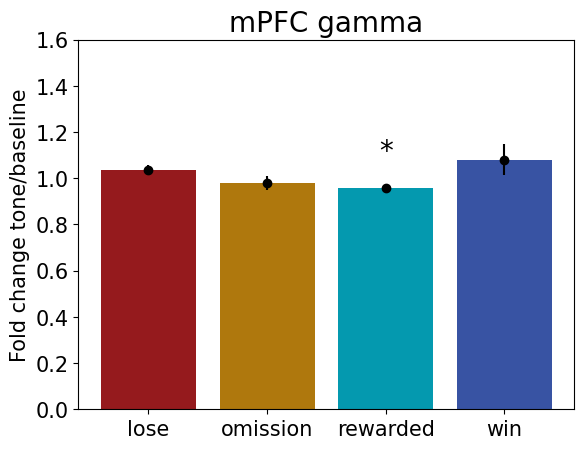

vHPC_theta_foldchange
lose
0.13728187661439506
omission
0.51708984375
rewarded
0.21339732464267147
win
0.06740146887023002


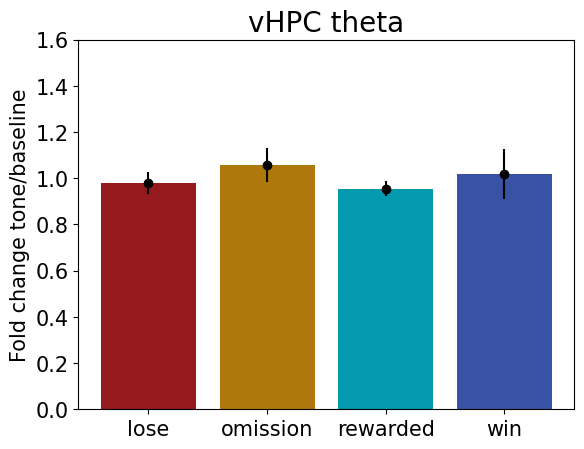

vHPC_beta_foldchange
lose
0.6465869590389275
omission
0.7118988037109375
rewarded
2.652742812183392e-07
win
0.019122868834529072


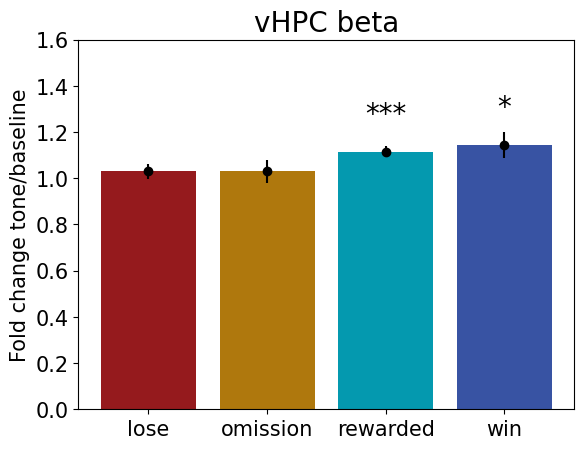

vHPC_gamma_foldchange
lose
0.0018117614653760938
omission
0.54766845703125
rewarded
0.48660091398606586
win
0.8020407048752531


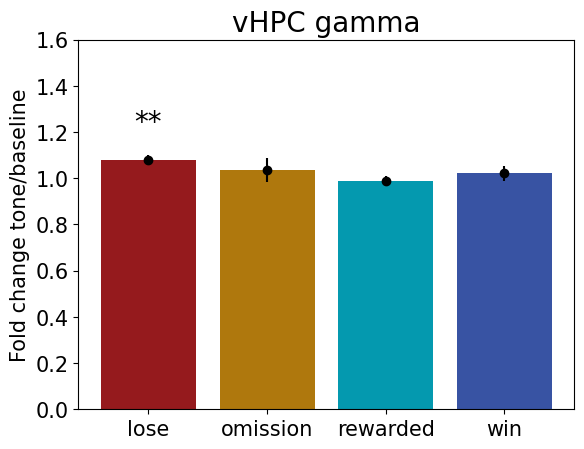

BLA_theta_foldchange
lose
0.11733161098788969
omission
0.050537109375
rewarded
0.025754839490163186
win
0.2011792931589298


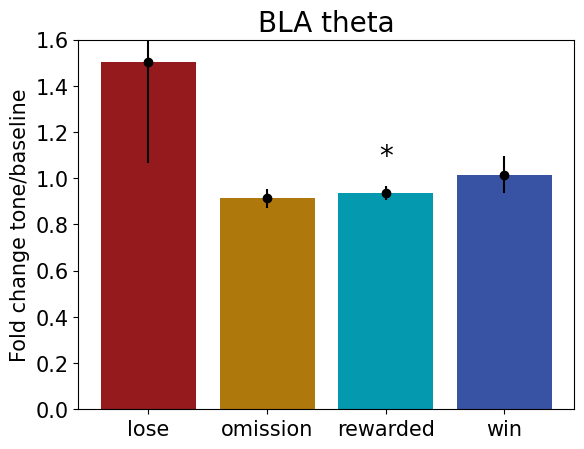

BLA_beta_foldchange
lose
0.008212454386921308
omission
0.243499755859375
rewarded
2.6560934927854264e-05
win
4.556449130177498e-05


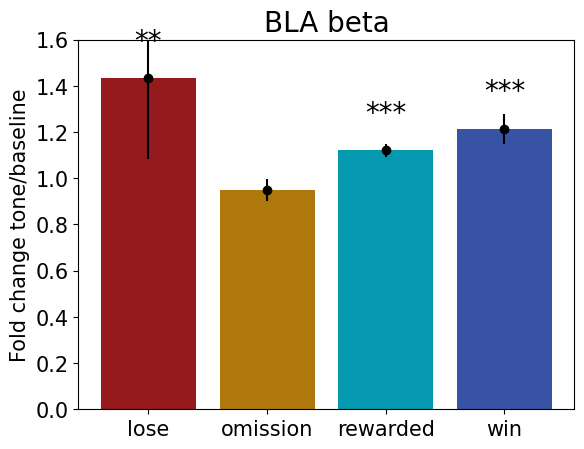

BLA_gamma_foldchange
lose
0.23398740961249587
omission
0.3778228759765625
rewarded
0.020149951109595398
win
0.9806487238383852


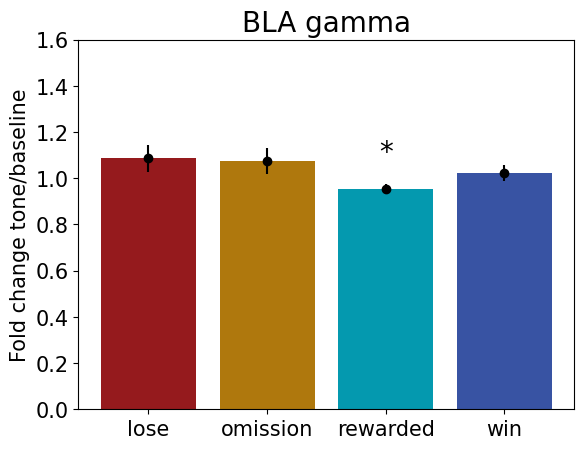

LH_theta_foldchange
lose
0.9910834918799765
omission
0.51708984375
rewarded
0.0067876925220265935
win
0.21306194551289082


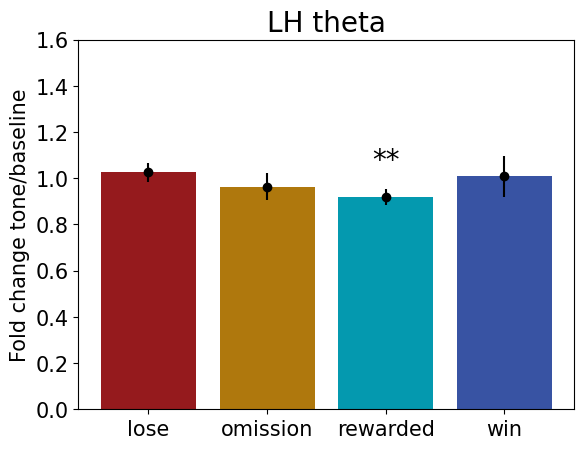

LH_beta_foldchange
lose
0.030130527591666123
omission
0.4037628173828125
rewarded
0.06950403844581267
win
0.3944658192922361


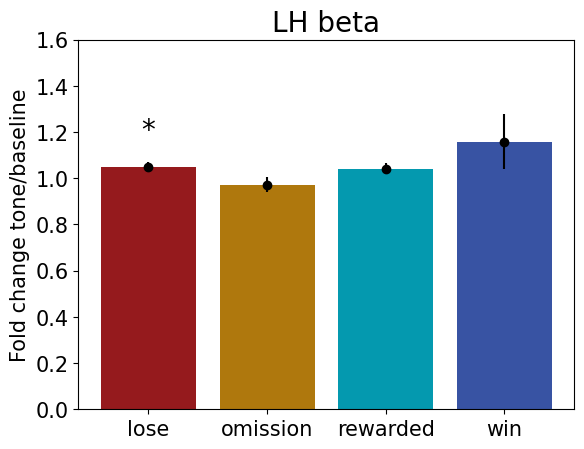

LH_gamma_foldchange
lose
0.2569978406882001
omission
0.17425537109375
rewarded
0.3700310432870314
win
0.04207135160686448


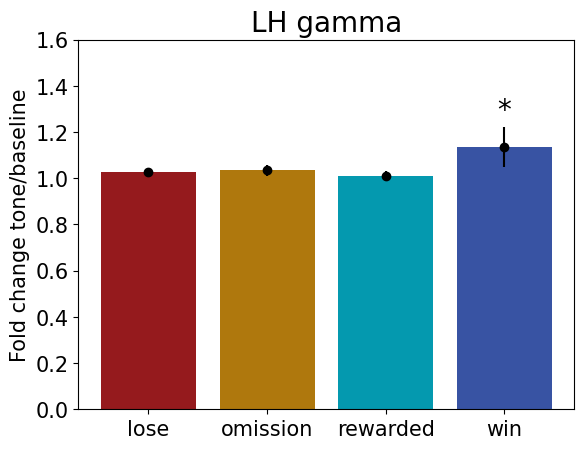

MD_theta_foldchange
lose
0.6546507386780149
omission
0.243499755859375
rewarded
0.010741661980702638
win
0.38546567782759666


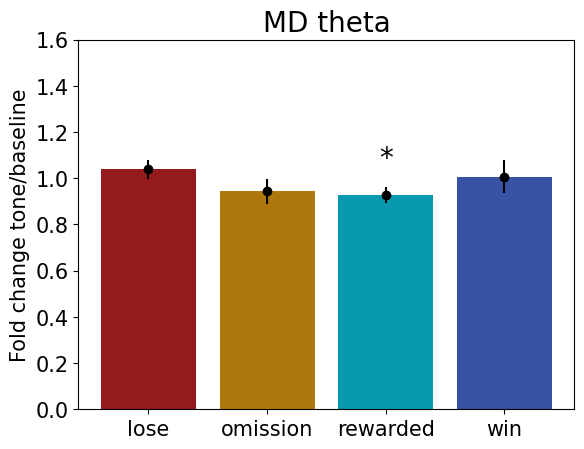

MD_beta_foldchange
lose
0.0032113792286736498
omission
0.2246856689453125
rewarded
0.401784691541306
win
0.6680349264643155


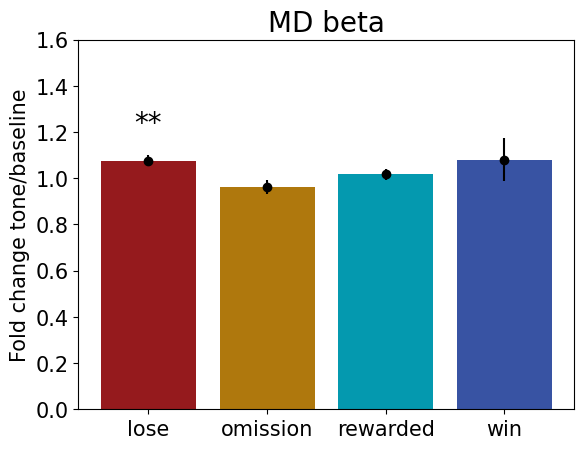

MD_gamma_foldchange
lose
0.0724836333747021
omission
0.120208740234375
rewarded
0.32651829182598224
win
0.23828783858334646


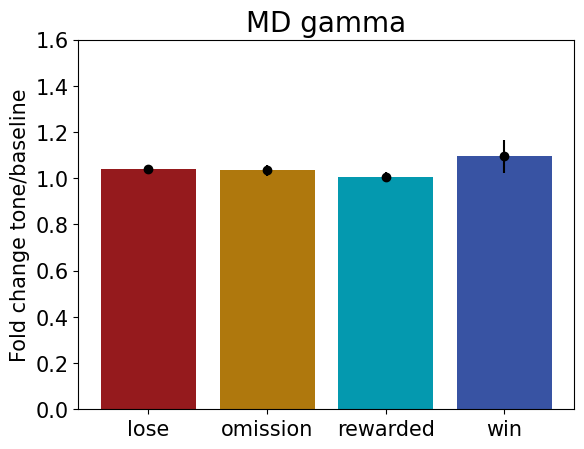

In [71]:
for col in foldchange_col:
    print(col)
    fig, ax = plt.subplots()
    plt.bar(mean_foldchange_df.index, mean_foldchange_df[col], color=mean_foldchange_df["color"])
    plt.ylim(0,1.6)
    plt.errorbar(mean_foldchange_df.index, mean_foldchange_df[col], yerr=sem_foldchange_df[col], fmt='o', color="black")
    # plt.legend()
    plt.title(" ".join(col.split("_")[:2]), fontsize=20)
    plt.ylabel("Fold change tone/baseline", fontsize=15)

    sig_star_dict = {}

    for index, row in grouped_MERGED_LFP_AND_SLEAP.iterrows():
        w_statistic, p_value = sign_test(row[col], mu0=1)
        w_statistic, p_value = stats.wilcoxon(np.array(row[col]) - 1)
        print(index)
        print(p_value)
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        plt.text(index, mean_foldchange_df[col][index] + 0.1, stars, ha='center', va='bottom', color='black', fontsize=20)
    # plt.show()
    # break
    plt.savefig("./proc/foldchange/{}_power_foldchange.png".format("_".join(col.split("_")[:2])))
    plt.savefig("./proc/foldchange/{}_power_foldchange.eps".format("_".join(col.split("_")[:2])))
    plt.show()

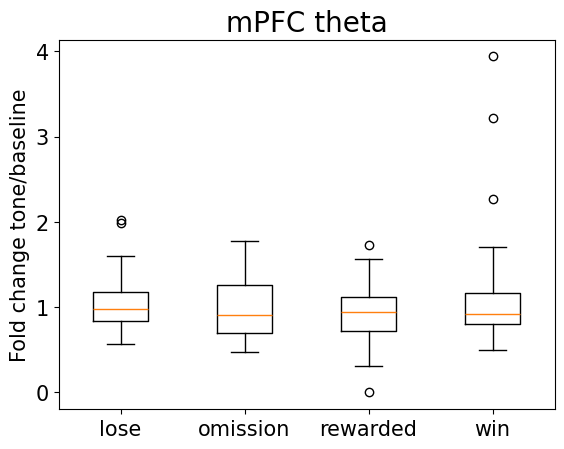

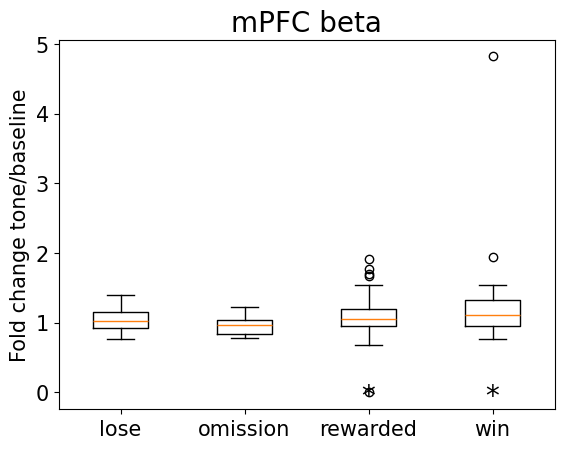

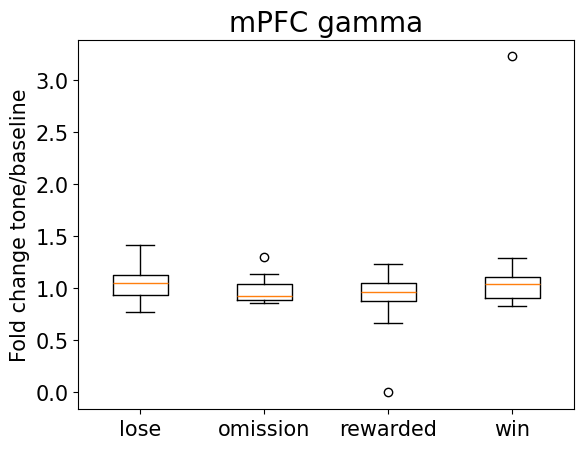

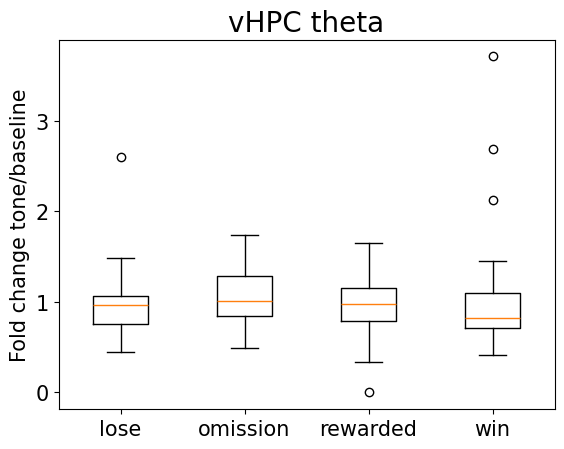

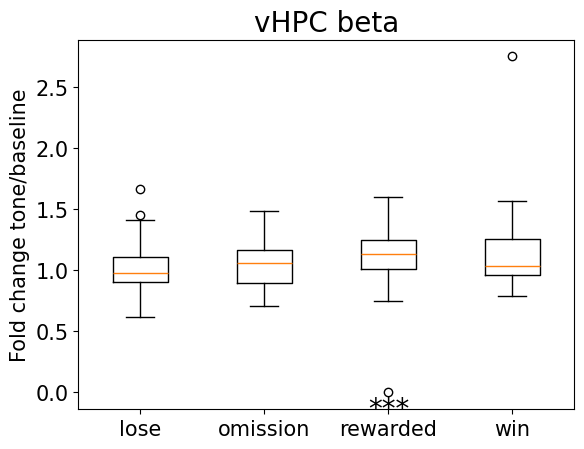

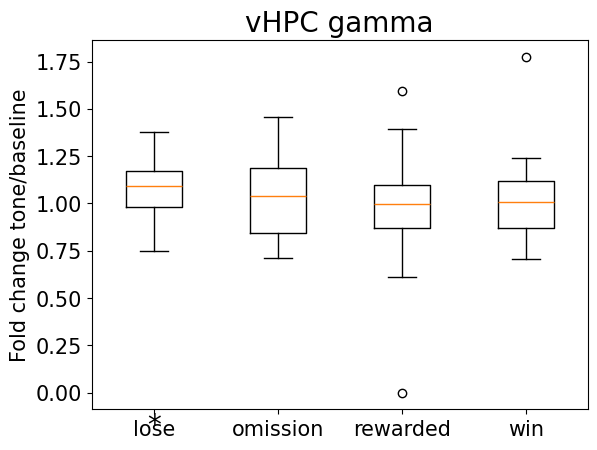

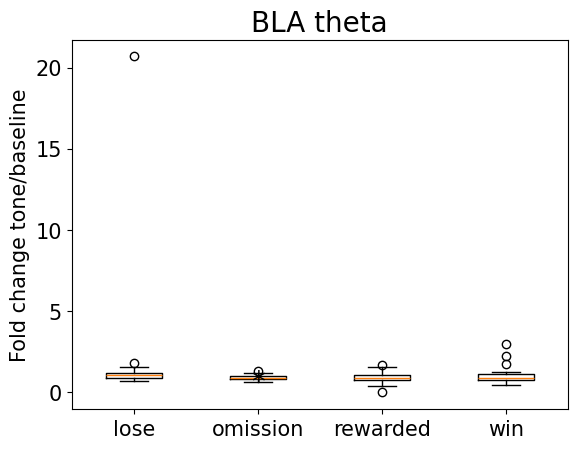

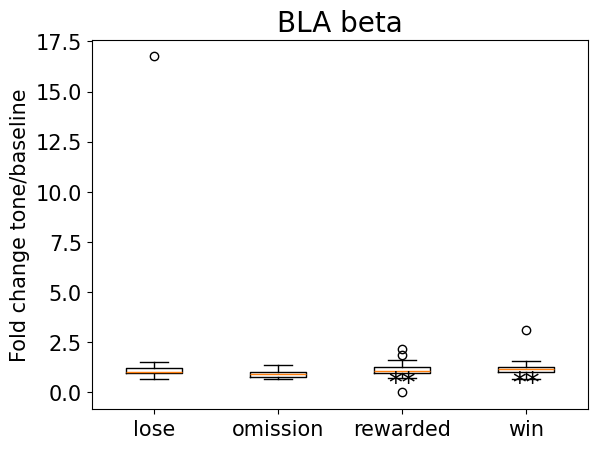

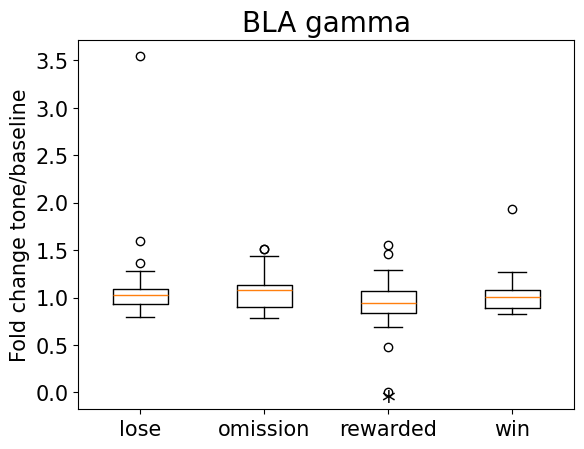

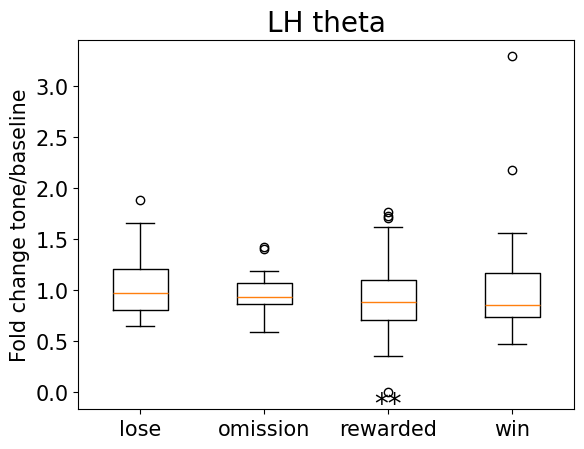

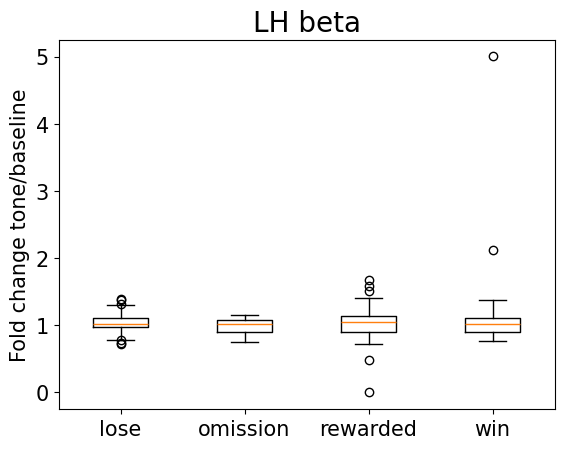

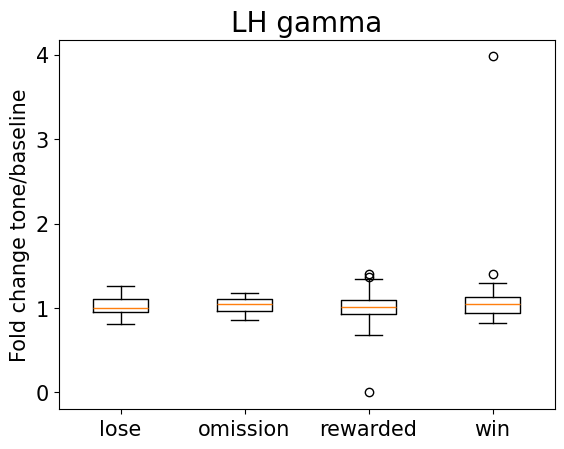

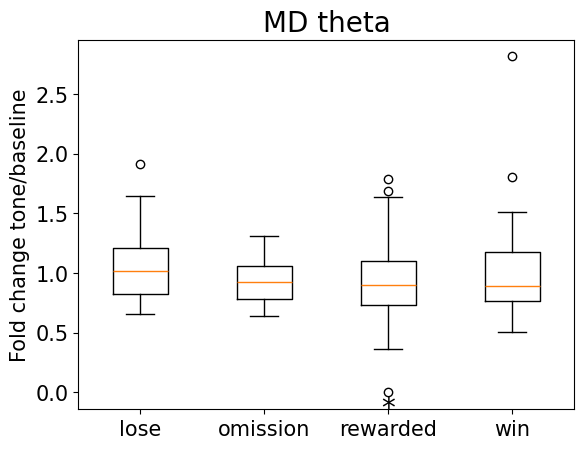

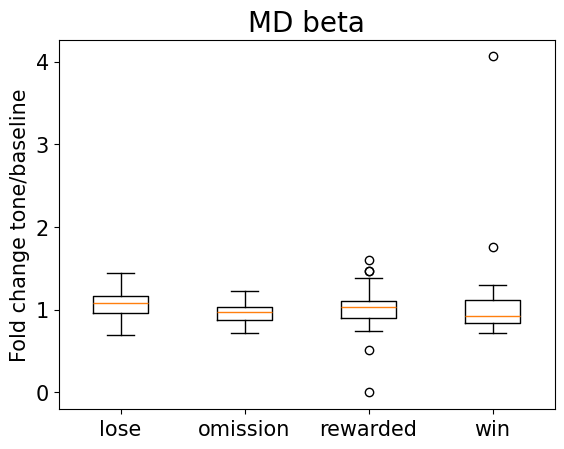

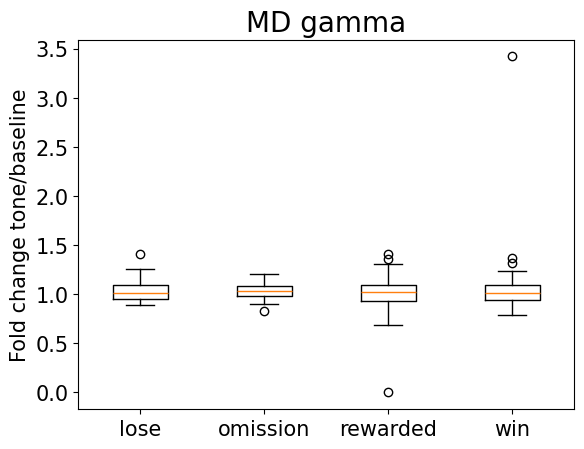

In [107]:
for col in foldchange_col:
    # print(col)
    fig, ax = plt.subplots()
    # plt.bar(mean_foldchange_df.index, mean_foldchange_df[col], color=mean_foldchange_df["color"])
    # plt.ylim(0,1.6)
    # plt.errorbar(mean_foldchange_df.index, mean_foldchange_df[col], yerr=sem_foldchange_df[col], fmt='o', color="black")
    # plt.legend()
    plt.title(" ".join(col.split("_")[:2]), fontsize=20)
    plt.ylabel("Fold change tone/baseline", fontsize=15)

    sig_star_dict = {}

    plt.boxplot(grouped_MERGED_LFP_AND_SLEAP[col], labels=grouped_MERGED_LFP_AND_SLEAP.index)
    for num, (index, row) in enumerate(grouped_MERGED_LFP_AND_SLEAP.iterrows()):
        w_statistic, p_value = sign_test(row[col], mu0=1)
        # w_statistic, p_value = stats.wilcoxon(np.array(row[col]) - 1)
        # print(index)
        # print(p_value)
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        plt.text(num+1, -0.25, stars, ha='center', va='bottom', color='black', fontsize=20)
    plt.savefig("./proc/foldchange/{}_power_foldchange_boxplot.png".format("_".join(col.split("_")[:2])))
    plt.savefig("./proc/foldchange/{}_power_foldchange_boxplot.eps".format("_".join(col.split("_")[:2])))

mPFC_theta_foldchange


ValueError: List of boxplot statistics and `positions` values must have same the length

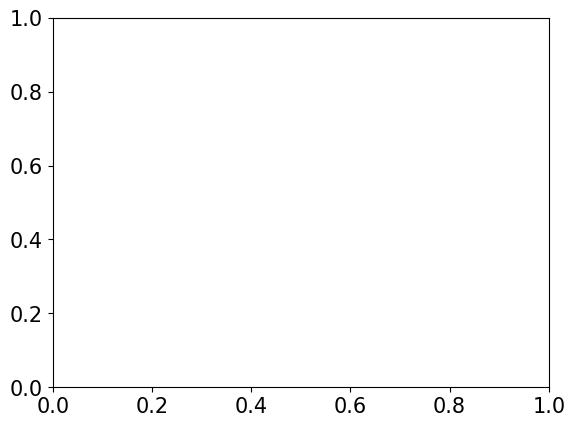

In [88]:
for col in foldchange_col:
    print(col)
    fig, ax = plt.subplots()
    # plt.bar(mean_foldchange_df.index, mean_foldchange_df[col], color=mean_foldchange_df["color"])
    plt.ylim(0,1.6)
    # plt.errorbar(mean_foldchange_df.index, mean_foldchange_df[col], yerr=sem_foldchange_df[col], fmt='o', color="black")
    # plt.legend()
    plt.title(" ".join(col.split("_")[:2]), fontsize=20)
    plt.ylabel("Fold change tone/baseline", fontsize=15)

    sig_star_dict = {}

    for index, row in grouped_MERGED_LFP_AND_SLEAP.iterrows():
        w_statistic, p_value = sign_test(row[col], mu0=1)
        w_statistic, p_value = stats.wilcoxon(np.array(row[col]) - 1)
        print(index)
        print(p_value)
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        # plt.text(index, mean_foldchange_df[col][index] + 0.1, stars, ha='center', va='bottom', color='black', fontsize=20)
        plt.boxplot(labels=)
    # plt.show()
    # break
    plt.savefig("./proc/foldchange/{}_power_foldchange.png".format("_".join(col.split("_")[:2])))
    plt.savefig("./proc/foldchange/{}_power_foldchange.eps".format("_".join(col.split("_")[:2])))
    plt.show()

In [ ]:
mean_foldchange_df[col][]

In [ ]:
# Example data: A dictionary of values and their corresponding p-values
data = {
    'A': (10, 0.04),  # Value, p-value
    'B': (15, 0.20),
    'C': (20, 0.01),
}

# Function to add significance stars based on p-values
def add_significance_stars(ax, data):
    for i, (key, (value, p_value)) in enumerate(data.items()):
        # Determine the significance level and corresponding star(s)
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        
        # Add stars to the plot if significant
        if stars:
            ax.text(i, value, stars, ha='center', va='bottom', color='black', fontsize=20)

# Create bar plot
fig, ax = plt.subplots()

# Plot the values
bars = ax.bar(data.keys(), [val[0] for val in data.values()])

# Call the function to add significance stars
add_significance_stars(ax, data)

# Show the plot
plt.show()